# Data Exploration

Explore the usefulness of data and perform some feature engineering

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
|  02/06/2025  | Martin | Create  | Notebook created. Started data processing | 
|  09/06/2025  | Martin | Update  | Added new features based on financial metrics | 
|  10/06/2025  | Martin | Update  | Permutation importance reveals no interesting columns. Need to find the highest across multiple rounds of testing | 
|  12/06/2025  | Martin | Update  | Used Permuatation importance, PCA, RBF Kernel approximation to create new datasets for testing training | 

# Content

- [Data Exploration](#data-exploration)
- [Feature Engineering](#feature-engineering)
- [Permutation Feature Importance](#permutation-feature-importance)
- [PCA](#pca)

# Data Exploration

* Train data covers period March 1, 2023, to February 29, 2024
* Timestamp not included in test data

<u>Submission Details</u>

* Submission can be in CSV or noteboook
* `ID` matches the row number starting from 1

Things to do
* Add new metrics
* permutation feature importance using RF
* pca
* tpot regressor

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from datetime import datetime, timedelta

In [2]:
df = pl.read_parquet("data/train.parquet")
# test = pl.read_parquet("data/test.parquet")

In [3]:
# Remove columns that contain inf
temp = df.columns[:-1]
cols_with_inf = [
  col for col in temp
  if df.select(pl.col(col).is_in([float('inf'), float('-inf')])).to_series().any()
]
df = df.drop(cols_with_inf)

In [4]:
df.head()

bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,…,X856,X857,X858,X859,X860,X861,X862,X863,X864,X865,X866,X867,X868,X869,X870,X871,X872,X873,X874,X875,X876,X877,X878,X879,X880,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890,label,timestamp
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns]
15.283,8.425,176.405,44.984,221.389,0.121263,-0.41769,0.005399,0.125948,0.058359,0.027359,0.03578,0.068219,1.034825,-0.029575,0.327805,0.485823,0.668596,0.617389,0.770037,0.857631,1.754456,0.572503,0.883229,0.58567,0.816321,0.529973,0.508244,0.448616,1.341892,1.406392,0.953631,1.183991,1.474789,0.774389,0.660586,0.269043,…,-0.216525,0.200508,0.492433,-0.51249,0.541286,-0.336399,-1.027483,0.21857,0.0,1.728155,0.62414,0.0,-0.051211,0.0,0.0,0.0,0.0,0.691754,0.242124,2.096157,3.369195,0.244667,0.286611,0.722679,0.901931,1.000007,1.925423,1.847943,0.005676,0.190791,0.369691,0.37763,0.210153,0.159183,0.530636,0.562539,2023-03-01 00:00:00
38.59,2.336,525.846,321.95,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,-0.183488,0.150526,0.308421,0.492232,0.529787,0.682958,0.770965,1.686504,0.273357,0.591695,0.442391,0.674792,0.460741,0.439681,0.380399,1.304113,1.003783,0.776628,1.015943,1.312735,0.696895,0.584217,0.231104,…,-0.180112,0.213252,0.479806,-0.180527,0.450331,-0.31915,-1.024055,0.088014,0.0,1.665698,0.622775,0.0,-0.079621,0.0,0.0,0.0,0.0,0.691665,0.242091,2.46103,4.127584,0.321394,0.31246,0.746452,0.912371,1.003153,1.928569,1.849468,0.005227,0.18466,0.363642,0.374515,0.209573,0.158963,0.530269,0.533686,2023-03-01 00:01:00
0.442,60.25,159.227,136.369,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,-0.261779,0.044571,0.200608,0.384558,0.476229,0.629848,0.718232,1.656707,0.140156,0.457268,0.376524,0.610116,0.429751,0.409316,0.350359,1.28325,0.760801,0.670816,0.917205,1.219124,0.653355,0.541739,0.210095,…,-0.265966,0.191734,0.440207,-0.108209,0.420681,-0.316953,-1.024056,-0.147363,0.0,1.666893,0.621414,0.0,-0.080427,0.0,0.0,0.0,0.0,0.691674,0.242093,2.493249,4.182112,0.326701,0.314636,0.746681,0.911129,1.002502,1.928047,1.849282,0.004796,0.178719,0.357689,0.371424,0.208993,0.158744,0.529901,0.546505,2023-03-01 00:02:00
4.865,21.016,335.742,124.963,460.705,0.072944,-0.43659,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,-0.535845,-0.273947,-0.124959,0.056438,0.311539,0.465377,0.554022,1.663491,0.152084,0.468778,0.383696,0.618529,0.435326,0.415523,0.356895,1.319538,0.955549,0.789646,1.044941,1.353001,0.72392,0.613462,0.246212,…,-0.322244,0.183687,0.404295,-0.169373,0.386584,-0.314775,-1.024058,-0.09459,0.0,1.735322,0.620057,0.0,-0.094702,0.0,0.0,0.0,0.0,0.69121,0.24193,2.525526,4.292975,0.350791,0.32357,0.753829,0.913363,1.002985,1.928621,1.849608,0.004398,0.172967,0.351832,0.368358,0.208416,0.158524,0.529534,0.357703,2023-03-01 00:03:00
27.158,3.451,98.411,44.407,142.818,0.17382,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,-0.430945,-0.205298,-0.062118,0.117266,0.341493,0.495591,0.584519,1.668419,0.156177,0.472732,0.3871,0.623192,0.439034,0.419868,0.361572,1.324595,0.90546,0.78375,1.047708,1.36188,0.732001,0.622712,0.251095,…,-0.369625,0.192377,0.415438,-0.198976,0.389969,-0.312628,-1.02406,0.162221,0.0,1.712096,0.618703,0.0,-0.091884,0.0,0.0,0.0,0.0,0.691207,0.241928,2.52443,4.306694,0.335599,0.31907,0.747533,0.908904,1.001286,1.927084,1.84895,0.004008,0.167391,0.346066,0.365314,0.207839,0.158304,0.529167,0.362452,2023-03-01 00:04:00


## Plots

Simple plots to get better sense of the data

In [5]:
def plot_ts(data: pl.DataFrame, col: str):
  plt.figure(figsize=(15, 5))
  plt.plot(df['timestamp'], df[col])
  plt.title(f"Trend of {col} values")

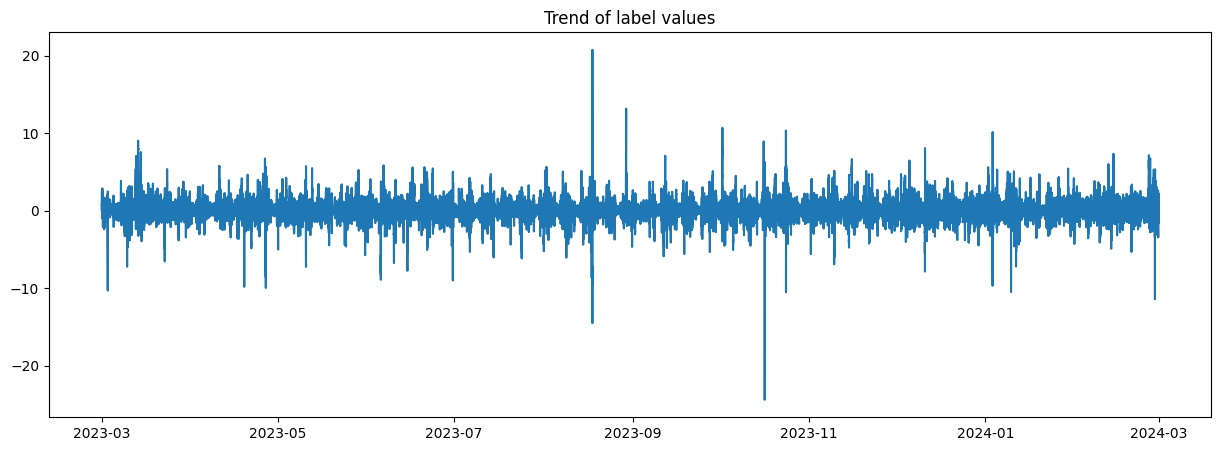

In [6]:
# Trend of label
plot_ts(df, 'label')

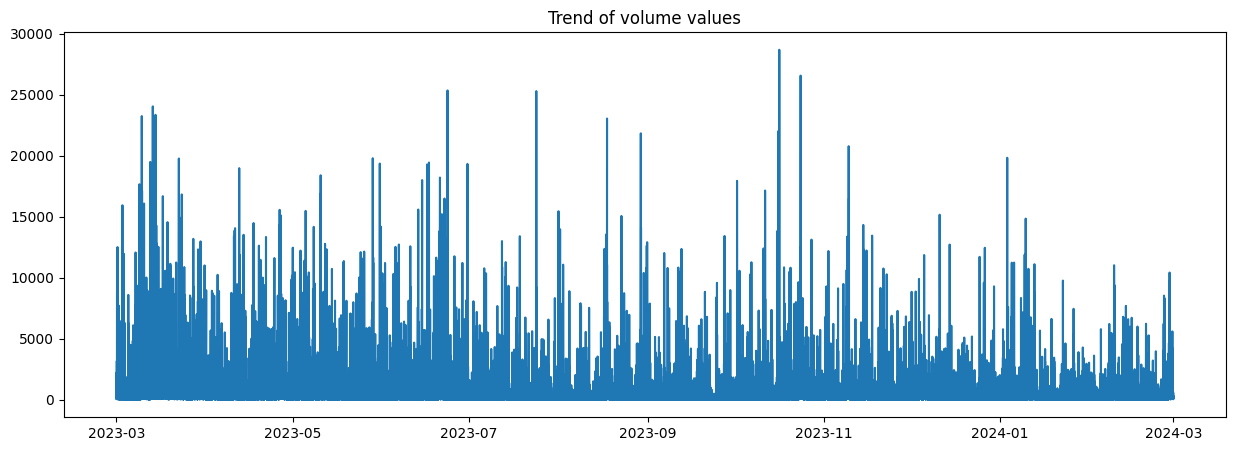

In [7]:
plot_ts(df, 'volume')

__Correlation Heatmap__

Found that lots of columns are correlated to each other.

* Most of the `X~` variables that are adjacent to each other are highly correlated
* `X1` - `X16` are all highly correlated to each other
* A lot of very funny correlation patterns in the data

In [8]:
# Get subset of columns else will crash kernel
cols = df.columns
subset = df.select(cols[270: 300])
corr = subset.corr()
corr = corr.with_columns([pl.col(col).round(2) for col in corr.columns])

<Axes: >

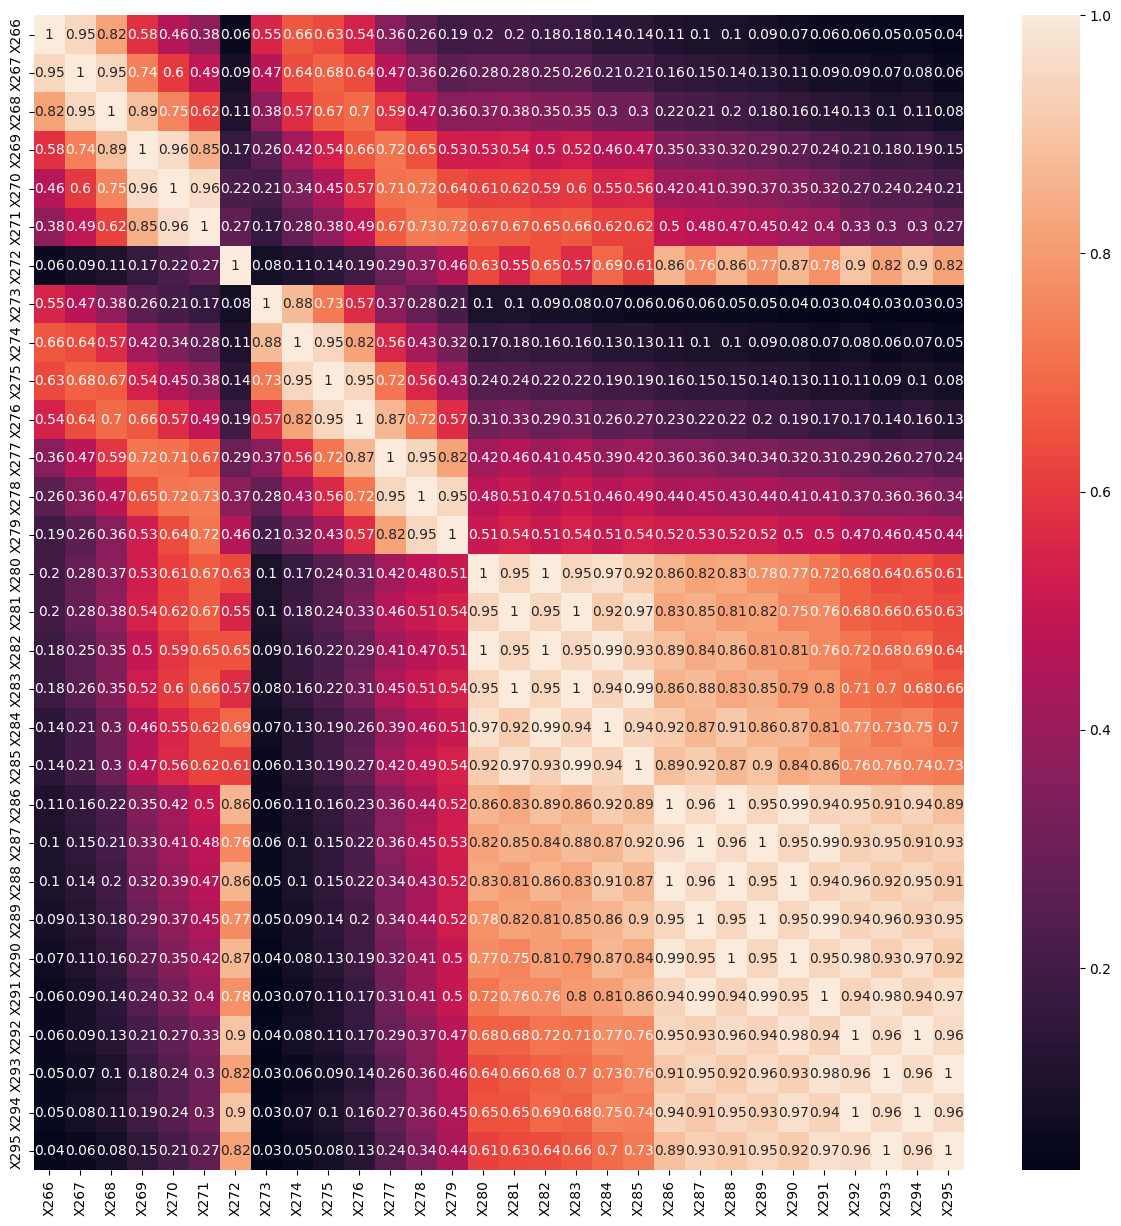

In [9]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)

---

# Feature Engineering

Create new features that are known to be useful in predicting price of cryptocurrencies based on the known feature columns.

1. Bid-Ask Imabalnce Ratio (BAIR) - Measure pressure from buyers vs. sellers in the order book. <1 = more selling pressure
2. Market Order Imbalance (MOI) - Indicates the imbalance in executed market orders. > may indicate upward price momentum
3. Order Flow Ratio (OFR) - Normalized measure of market order pressure. +ve means net buying
4. Liquidity Pressure Ratio (LPR) - A broader view of demand vs. supply combining order book and market orders
5. Order Book Strength (OBS) - Raw pressure balance. Large positive values = buyer dominance.
6. Volume Weighted Order Imbalance (VWOI) - Order imbalance weighted by the volume and price midpoint.
7. Volume Acceleration (VA) - Measures the speed of volume change, helpful for identifying sudden spikes in activity that often precede price movement
8. Order Book Relative Strength Index (OB-RSI) - Adapted from RSI (Relative Strength Index), but applied to order flow

In [10]:
def create_new_metrics(df: pl.DataFrame, st_ts: datetime | None = None) -> pl.DataFrame:
  # Static additional metrics
  df = df.with_columns(
    bair = pl.col('bid_qty') / pl.col('ask_qty'),
    moi = pl.col('buy_qty') / pl.col('sell_qty'),
    ofr = (pl.col('buy_qty') - pl.col('sell_qty')) / (pl.col('buy_qty') + pl.col('sell_qty')),
    lpr = (pl.col('bid_qty') + pl.col('buy_qty')) / (pl.col('ask_qty') + pl.col('sell_qty')),
    obs = (pl.col('bid_qty') + pl.col('buy_qty') - (pl.col('ask_qty') + pl.col('sell_qty'))),
    vwoi = (pl.col('buy_qty') - pl.col('sell_qty')) / pl.col('volume'),
    va = (pl.col('volume').diff())
  )

  # Window functions
  df = df.with_columns(
    obrsi = 100 - (100 / (1 + pl.col('buy_qty').rolling_mean(window_size=10) / pl.col('sell_qty').rolling_mean(window_size=10)))
  )

  # If it's the test set, then add a timestamp column
  if st_ts:
    dt = [st_ts + timedelta(hours=i) for i in range(df.shape[0])]
    df = df.with_columns(
      pl.Series('timestamp', dt)
    )
  
  # Fill all null values with mean
  df = df.with_columns(
    pl.col('va').fill_null(strategy='backward'),
    pl.col('obrsi').fill_null(strategy='backward'),
  )
  return df

In [11]:
df = create_new_metrics(df)
# create_new_metrics(test, st_ts=datetime(2024, 2, 29, 0, 0, 0))

In [ ]:
# Optional: Export data
# df.write_csv("data/clean/orig_plus.csv")

---

# Permutation Feature Importance

First method in identifying key variables. Permutation importance on feature columns

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import r_regression
from scipy.stats import pearsonr

In [41]:
# Subset df for testing purposes
perc_subset = 0.45
df_subset = df.slice(offset=0, length=int(df.shape[0] * perc_subset))

In [42]:
# Take the last perc rows as the validation set
perc_valid = 0.15
num_valid = int(df_subset.shape[0] * (1 - perc_valid))
train = df_subset.slice(offset=0, length=num_valid)
valid = df_subset.slice(offset=num_valid, length=df_subset.shape[0] - num_valid)

# Split X and y
y_train = train['label']
X_train = train.drop(['label', 'timestamp'])
y_valid = valid['label']
X_valid = valid.drop(['label', 'timestamp'])

In [43]:
X_train.shape

(201151, 882)

In [44]:
X_valid.shape

(35498, 882)

In [45]:
# # Baseline Decision Tree
# base = DecisionTreeRegressor(
#   max_depth=5,
#   random_state=43
# )
# base.fit(X_train, y_train)

# Baseline RF
base = RandomForestRegressor(
  n_estimators=10,
  max_depth=6,
  random_state=43
)
base.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=43)

In [ ]:
# Permutation importance 
perm_impt = permutation_importance(base, X_valid, y_valid, n_repeats=3, random_state=42)

In [ ]:
df_impt = pl.DataFrame({
  'col': X_valid.columns,
  'impt_mean': perm_impt.importances_mean,
  'impt_sd': perm_impt.importances_std
})

df_impt = df_impt.sort('impt_mean')

df_impt = df_impt.filter(
  pl.col('impt_mean') > 0
)

print(df_impt.head())
print(df_impt.shape)

# # Optional: Saved data
# cols_to_save = list(df_impt['col'])
# cols_to_save.append('timestamp')
# cols_to_save.append('label')
# save = df.select(cols_to_save)
# save.write_csv("data/clean/perm_impt_45.csv")

shape: (5, 3)
┌──────┬───────────┬───────────┐
│ col  ┆ impt_mean ┆ impt_sd   │
│ ---  ┆ ---       ┆ ---       │
│ str  ┆ f64       ┆ f64       │
╞══════╪═══════════╪═══════════╡
│ X856 ┆ 0.000004  ┆ 0.000003  │
│ X392 ┆ 0.000005  ┆ 4.7158e-9 │
│ X841 ┆ 0.000006  ┆ 0.000008  │
│ X853 ┆ 0.000008  ┆ 0.000044  │
│ X119 ┆ 0.000011  ┆ 0.000008  │
└──────┴───────────┴───────────┘
(53, 3)


Every round produces a different set of results. Need to run another set of tests checking positive values across different subsets of data

---

# PCA

Testing 2 methods of PCA:

1. Standard PCA that uses eigenvalues
2. Approximate a kernel map using a subset of the training data

In [1]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

In [18]:
N_COMPONENTS = 120

df_pca = df.drop(['label', 'timestamp'])
# Drop additional columns because some of them are nan
df_pca = df_pca.drop(['moi', 'ofr', 'vwoi'])

# Normalise all columns
scaler = StandardScaler()
pca_arr = scaler.fit_transform(df_pca)

# Define and train pca
pca = PCA(n_components=N_COMPONENTS)
pca_arr = pca.fit_transform(pca_arr)

# print(pca.explained_variance_ratio_)
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_)}")
print(f"Variance explained by first 5 principle components:")
print(pca.explained_variance_ratio_[:5])
# print(pca.singular_values_)

Total variance explained: 0.9032070190503053
Variance explained by first 5 principle components:
[0.14527114 0.06513532 0.04435164 0.04331634 0.0370366 ]


In [21]:
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    """Routine to generate a high-quality biplot"""

    pca1 = pcax - 1
    pca2 = pcay - 1
    xs = score[:, pca1]
    ys = score[:, pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0 / (xs.max() - xs.min())
    scaley = 2.0 / (ys.max() - ys.min())
    text_scale_factor = 1.5

    plt.figure(figsize=(10, 9))
    plt.scatter(xs * scalex, ys * scaley, s=1)

    for i in range(n):
        plt.arrow(0, 0, coeff[i, pca1], coeff[i, pca2], color="r", alpha=0.5)
        if labels is None:
            plt.text(
                coeff[i, pca1] * text_scale_factor,
                coeff[i, pca2] * text_scale_factor,
                "Var" + str(i + 1),
                color="g",
                ha="center",
                va="center",
            )
        else:
            plt.text(
                coeff[i, pca1] * text_scale_factor,
                coeff[i, pca2],
                labels[i],
                color="g",
                ha="center",
                va="center",
            )
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    plt.tight_layout()

    return

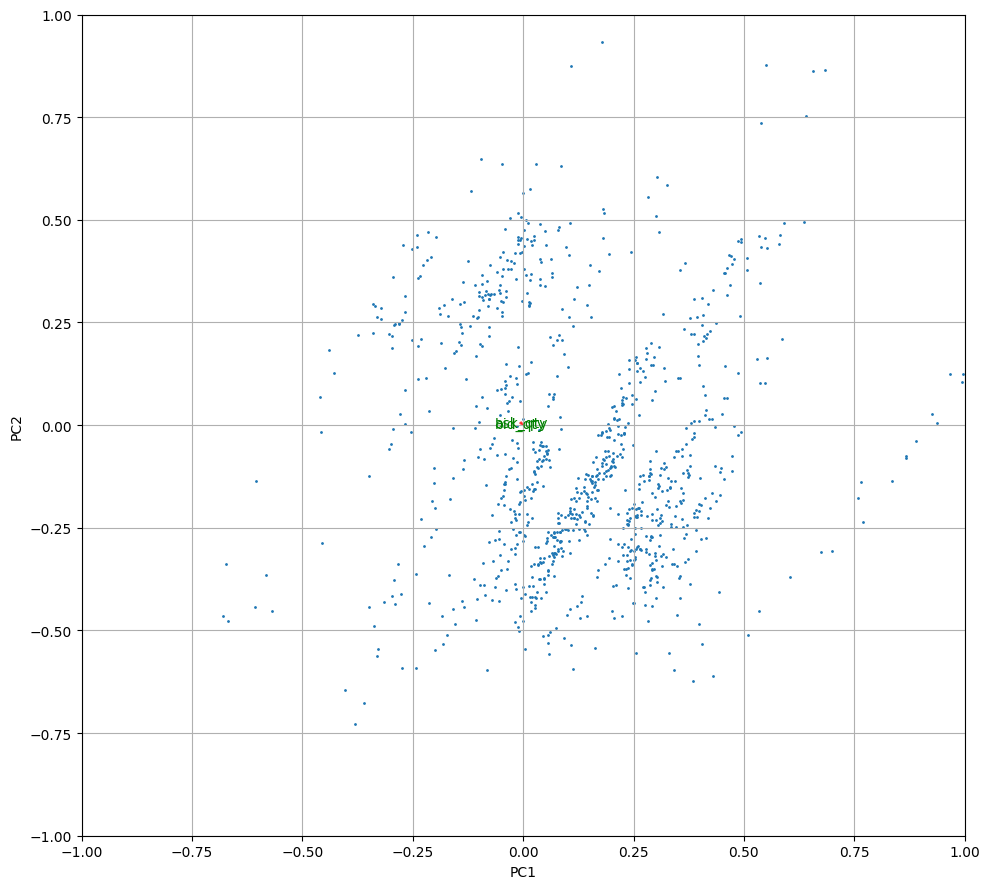

In [22]:
biplot(pca_arr[:1000, :], np.transpose(pca.components_[0:2, 0:2]), 5, 1, 2, labels=list(df_pca.columns))

In [ ]:
# Make dataframe and export data
pca_cols = [f"pca_{i}" for i in range(1, pca_arr.shape[1]+1)]
save_pca = pl.DataFrame(pca_arr, schema=pca_cols)
save_pca = save_pca.with_columns(
  timestamp = df['timestamp'],
  label= df['label']
)

# Optional: Save dataframe
# save_pca.write_csv("data/clean/pca_120.csv")

After testing KernelPCA, it requires too much memory to compute. We use a kernel approximation method, `RBFSampler`, that approximate feature mappings that match kernels.

In [ ]:
SUBSET_PERC = 0.5
N_COMPONENTS = 120

df_rbf = df.drop(['label', 'timestamp'])
# Drop additional columns because some of them are nan
df_rbf = df_rbf.drop(['moi', 'ofr', 'vwoi'])

# Select a subset of rows
# np.random.seed(43)
# num_rows = int(df_rbf.shape[0] * SUBSET_PERC)
# # rand_idx = np.random.choice(range(df_rbf.shape[0]), size=num_rows, replace=False)
# rbf_subset_arr = df_rbf.to_numpy()[:num_rows]

# Perform kernel approximation
rbf_samp = RBFSampler(
  gamma=1,
  random_state=43,
  n_components=N_COMPONENTS
)
rbf_arr = rbf_samp.fit_transform(df_rbf.to_numpy())

In [19]:
# Make dataframe and export data
rbf_cols = [f"rbf_{i}" for i in range(1, rbf_arr.shape[1]+1)]
save_rbf = pl.DataFrame(rbf_arr, schema=rbf_cols)
save_rbf = save_rbf.with_columns(
  timestamp = df['timestamp'],
  label= df['label']
)

# Optional: Save dataframe
save_rbf.write_csv("data/clean/rbf_120.csv")